In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
import math
import os

In [28]:
df = pd.read_csv("data/df_pp.csv")

In [29]:
n_clusters = 10

num_cols = df.select_dtypes(include="number").columns
scaler = StandardScaler()       
scaler.fit(df[num_cols])         
X_scaled = scaler.transform(df[num_cols])

# Rodar fuzzy c-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, c=n_clusters, m=2, error=0.001, maxiter=1000
)

labels = u.argmax(axis=0)

df_scaled = df.copy()
for i, col in enumerate(num_cols):
    df_scaled[col] = X_scaled[:, i]

df_scaled["cluster_fuzzy"] = labels

for idx in range(n_clusters):
    df_scaled[f"pertinencia_cluster_{idx}"] = u[idx]

df_scaled.to_csv(f"data/df_agrupamentofuzzy_{n_clusters}.csv", index=False)
print("Arquivo salvo com features normalizadas!")


Arquivo salvo com features normalizadas!


In [30]:
caminho = f"data/df_agrupamentofuzzy_{n_clusters}.csv"
os.makedirs("results", exist_ok=True)
df = pd.read_csv(caminho, engine="pyarrow")

# (resto do código igual)
plt.figure(figsize=(8, 6))
plt.scatter(
    df['TIM_THROU_USER_PDCP_DL (Kbps)'],
    df['TIM_PRB_UTIL_MEAN_DL (%)'],
    c=df['cluster_fuzzy'],
    cmap='viridis',
    s=10
)
plt.title(f'Fuzzy C Means Throughput vs PRB util - Clusters: {n_clusters}')
plt.xlabel('Throughput DL (Kbps)')
plt.ylabel('PRB Util Mean DL (%)')

nome_saida = os.path.join("results", f"df_agrupamentofuzzy_{n_clusters}.png")
plt.savefig(nome_saida, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Gráfico salvo em {nome_saida}")


✅ Gráfico salvo em results\df_agrupamentofuzzy_10.png


In [31]:
cluster_means = df.groupby("cluster_fuzzy")[num_cols].mean()

# Normalizar cada coluna para [0, 1] só para visualização
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Criar ângulos igualmente espaçados para cada variável
num_vars = len(num_cols)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # fechar o gráfico

# Criar o gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plotar cada cluster
for cluster_label, row in cluster_means_norm.iterrows():
    values = row.tolist()
    values += values[:1]  # fechar o gráfico
    ax.plot(angles, values, label=f"Cluster {cluster_label}", linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Adicionar rótulos
ax.set_xticks(angles[:-1])
ax.set_xticklabels(num_cols, fontsize=8)
ax.set_title(f"Radar Chart - Fuzzy C-Means ({len(cluster_means)} clusters)", size=13)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Salvar gráfico
os.makedirs("results", exist_ok=True)
nome_saida = os.path.join("results", f"radar_fuzzy_{n_clusters}clusters.png")
plt.savefig(nome_saida, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Gráfico radar salvo em {nome_saida}")

✅ Gráfico radar salvo em results\radar_fuzzy_10clusters.png


In [32]:
cluster_means_norm

,TIM_PRB_AVAIL (Unid),TIM_PRB_UTIL_MEAN_DL (%),TIM_THROU_USER_PDCP_DL (Kbps),TIM_USERS_RRC_CONN_MEAN_SUM_ALLOP (Unid),TIM_VOLUME_DADOS_DLUL_ALLOP (KB),TIM_VOLUME_DADOS_DL_ALLOP (KB)
cluster_fuzzy,,,,,,
0,0.445950,0.074278,0.604508,0.059964,0.045007,0.046196
1,0.884976,0.357353,0.415600,0.207215,0.231619,0.237961
2,0.398102,0.960017,0.016810,0.503248,0.532170,0.538742
3,0.058761,0.094090,0.320236,0.027403,0.023319,0.024075
4,0.951424,0.046094,1.000000,0.056193,0.052789,0.055979
5,0.000000,0.057907,0.000000,0.010579,0.000000,0.000000
6,0.072374,0.360142,0.207750,0.129550,0.128126,0.129765
7,0.940986,1.000000,0.153529,1.000000,1.000000,1.000000
8,0.221639,0.715743,0.074548,0.278743,0.301341,0.306463


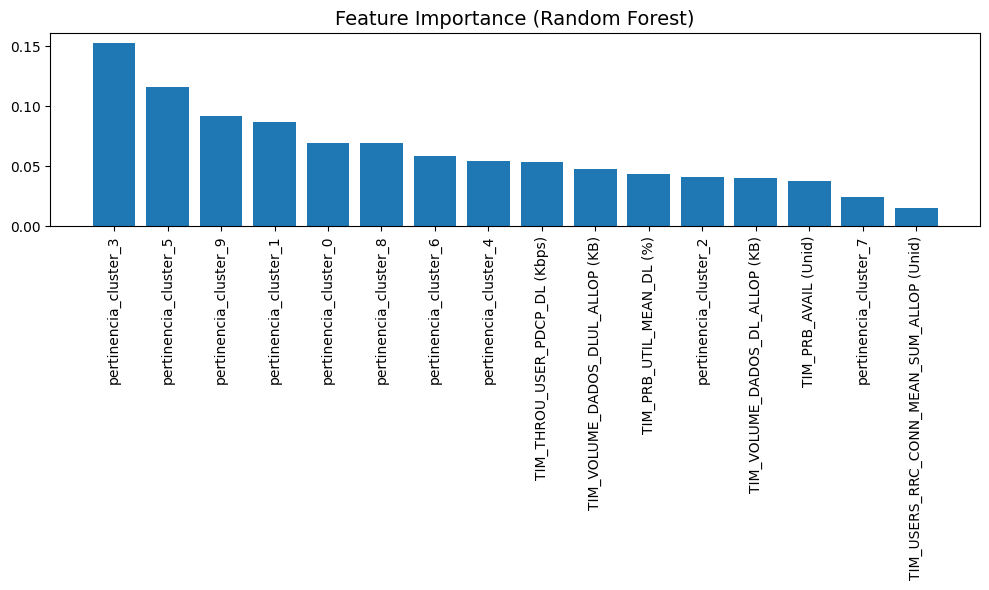

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Separar features numéricas e target
num_cols = df.select_dtypes(include="number").columns.drop("cluster_fuzzy")
X = df[num_cols]
y = df["cluster_fuzzy"]

# Treinar Random Forest para extrair importâncias
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# Importâncias das features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotar gráfico
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_cols)), importances[indices], align="center")
plt.xticks(range(len(num_cols)), num_cols[indices], rotation=90)
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.tight_layout()
plt.show()

